<table>
    <tr>
        <td><img src="./img/Macc.png" width="auto"/></td>
        <td>
            <table><tr>
            <h1 style="color:blue;text-align:center">Lógica para Ciencias de la Computación</h1></td>
            </tr></table>   
        <td>&nbsp;</td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Taller</p></tp>
            <tp><p style="font-size:150%;text-align:center">Solución de problemas</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---

# Objetivo <a class="anchor" id="inicio"></a>

En clase hemos visto el siguiente esquema del procedimiento para solucionar problemas:

<img src="./img/mapa.png" width="400px"/>

Implementaremos este esquema en Python usando las herramientas desarrolladas hasta este momento.

# Secciones

1. [Problema ilustrativo.](#prob)
2. [Implementación de las restricciones.](#forms)
3. [Visualización.](#vis)
4. [Solución mediante SATtabla.](#sat)
5. [Un problema más difícil.](#prob2)
6. [Situaciones más complejas y comparación de tiempos.](#comp)

# Problema de ejemplo <a class="anchor" id="prob"></a>

([Volver al inicio](#inicio))

Comenzaremos con el problema presentado en las diapositivas de clase, que repetimos aquí por conveniencia:

<img src="./img/problema.png" width="400px"/>

Las restricciones y su representación usando lógica proposicional son las siguientes:

1. Debe haber exactamente tres caballos en el tablero:

$$\bigvee_{(x_1,y_1)\in\texttt{Casillas}}\bigvee_{(x_2,y_2)\neq(x_1,y_1)}\bigvee_{{(x_3,y_3)\neq(x_1,y_1)\\(x_3,y_3)\neq(x_2,y_2)}}\left(CenC_{(x_1,y_1)}\wedge CenC_{(x_2,y_2)}\wedge CenC_{(x_3,y_3)}\right)\wedge\bigwedge_{(u,v)\neq(x_1,y_1)\\(u,v)\neq(x_2,y_2)\\(u,v)\neq(x_3,y_3)}\neg CenC_{(u,v)}\Bigr)$$

2. Ningún caballo debe poder atacar a otro.

\begin{align*}
&CenC_{(0,0)}\to \neg(CenC_{(1,2)} \vee CenC_{(2,1)})\\
&CenC_{(1,0)}\to \neg(CenC_{(0,2)} \vee CenC_{(2,2)})\\
&CenC_{(2,0)}\to \neg(CenC_{(1,2)} \vee CenC_{(0,1)})\\
&CenC_{(0,1)}\to \neg(CenC_{(2,2)} \vee CenC_{(2,0)})\\
&CenC_{(2,1)}\to \neg(CenC_{(0,2)} \vee CenC_{(0,0)})\\
&CenC_{(0,2)}\to \neg(CenC_{(1,0)} \vee CenC_{(2,1)})\\
&CenC_{(1,2)}\to \neg(CenC_{(0,0)} \vee CenC_{(2,0)})\\
&CenC_{(2,2)}\to \neg(CenC_{(0,1)} \vee CenC_{(1,0)})\\
\end{align*}


3. Debe haber un caballo en la casilla $(1,2)$.

$$CenC_{(1,2)}$$

## Implementación de las restricciones <a class="anchor" id="forms"></a>

([Volver al inicio](#inicio))

En la librería `Problemas` hemos implementado las tres reglas. Puede correr el siguiente código para visualizar el resultado, y puede entrar a la librería para explorar la implementación:

In [1]:
from itertools import product
import numpy as np
from copy import deepcopy

class Formula :

    def __init__(self) :
        pass

    def __str__(self) :
        if type(self) == Letra:
            return self.letra
        elif type(self) == Negacion:
            return '-' + str(self.subf)
        elif type(self) == Binario:
            return "(" + str(self.left) + self.conectivo + str(self.right) + ")"

    def letras(self):
        if type(self) == Letra:
            return set(self.letra)
        elif type(self) == Negacion:
            return self.subf.letras()
        elif type(self) == Binario:
            return self.left.letras().union(self.right.letras())

    def subforms(self):
        if type(self) == Letra:
            return [str(self)]
        elif type(self) == Negacion:
            return list(set([str(self)] + self.subf.subforms()))
        elif type(self) == Binario:
            return list(set([str(self)] + self.left.subforms() + self.right.subforms()))

    def valor(self, I) :
        if type(self) == Letra:
            return I[self.letra]
        elif type(self) == Negacion:
            return not self.subf.valor(I)
        elif type(self) == Binario:
            if self.conectivo == 'Y':
                return self.left.valor(I) and self.right.valor(I)
            if self.conectivo == 'O':
                return self.left.valor(I) or self.right.valor(I)
            if self.conectivo == '>':
                return not self.left.valor(I) or self.right.valor(I)
            if self.conectivo == '=':
                return (self.left.valor(I) and self.right.valor(I)) or (not self.left.valor(I) and not self.right.valor(I))

    def SATtabla(self):
        letras = list(self.letras())
        n = len(letras)
        valores = list(product([True, False], repeat=n))
        for v in valores:
            I = {letras[x]: v[x] for x in range(n)}
            if self.valor(I):
                return I
        return None

    def clasifica_para_tableaux(self):
        if type(self) == Letra:
            return None, 'literal'
        elif type(self) == Negacion:
            if type(self.subf) == Letra:
                return None, 'literal'
            elif type(self.subf) == Negacion:
                return 1, 'alfa'
            elif type(self.subf) == Binario:
                if self.subf.conectivo == 'O':
                    return 3, 'alfa'
                elif self.subf.conectivo == '>':
                    return 4, 'alfa'
                elif self.subf.conectivo == 'Y':
                    return 1, 'beta'
        elif type(self) == Binario:
            if self.conectivo == 'Y':
                return 2, 'alfa'
            elif self.conectivo == 'O':
                return 2, 'beta'
            elif self.conectivo == '>':
                return 3, 'beta'

    def SATtableaux(self):
        estado = nodos_tableaux([self])
        res = estado.es_hoja()
        if res == 'cerrada':
            return None
        elif res == 'abierta':
            return estado.interp()
        frontera = [estado]
        while len(frontera) > 0:
            estado = frontera.pop(0)
            hijos = estado.expandir()
            for a in hijos:
                if a != None:
                    res = a.es_hoja()
                    if res == 'abierta':
                        return a.interp()
                    elif res == None:
                        frontera.append(a)
        return None

    def ver(self, D):
        '''
        Visualiza una fórmula A (como string en notación inorder) usando el descriptor D
        '''
        vis = []
        A = str(self)
        for c in A:
            if c == '-':
                vis.append(' no ')
            elif c in ['(', ')']:
                vis.append(c)
            elif c in ['>', 'Y', 'O']:
                vis.append(' ' + c + ' ')
            elif c == '=':
                vis.append(' sii ')
            else:
                try:
                    vis.append(D.escribir(c))
                except:
                    raise("¡Caracter inválido!")
        return ''.join(vis)

class Letra(Formula) :
    def __init__ (self, letra:str) :
        self.letra = letra

class Negacion(Formula) :
    def __init__(self, subf:Formula) :
        self.subf = subf

class Binario(Formula) :
    def __init__(self, conectivo:str, left:Formula, right:Formula) :
        assert(conectivo in ['Y','O','>','='])
        self.conectivo = conectivo
        self.left = left
        self.right = right

def inorder_to_tree(cadena:str):
    conectivos = ['Y', 'O', '>', '=']
    if len(cadena) == 1:
        return Letra(cadena)
    elif cadena[0] == '-':
        return Negacion(inorder_to_tree(cadena[1:]))
    elif cadena[0] == "(":
        counter = 0 #Contador de parentesis
        for i in range(1, len(cadena)):
            if cadena[i] == "(":
                counter += 1
            elif cadena[i] == ")":
                counter -=1
            elif cadena[i] in conectivos and counter == 0:
                return Binario(cadena[i], inorder_to_tree(cadena[1:i]),inorder_to_tree(cadena[i + 1:-1]))
    else:
        raise Exception('¡Cadena inválida!')

class Descriptor :

    '''
    Codifica un descriptor de N argumentos mediante un solo caracter
    Input:  args_lista, lista con el total de opciones para cada
                     argumento del descriptor
            chrInit, entero que determina el comienzo de la codificación chr()
    Output: str de longitud 1
    '''

    def __init__ (self,args_lista,chrInit=256) :
        self.args_lista = args_lista
        assert(len(args_lista) > 0), "Debe haber por lo menos un argumento"
        self.chrInit = chrInit
        self.rango = [chrInit, chrInit + np.prod(self.args_lista)]

    def check_lista_valores(self,lista_valores) :
        for i, v in enumerate(lista_valores) :
            assert(v >= 0), "Valores deben ser no negativos"
            assert(v < self.args_lista[i]), f"Valor debe ser menor o igual a {self.args_lista[i]}"

    def codifica(self,lista_valores) :
        self.check_lista_valores(lista_valores)
        cod = lista_valores[0]
        n_columnas = 1
        for i in range(0, len(lista_valores) - 1) :
            n_columnas = n_columnas * self.args_lista[i]
            cod = n_columnas * lista_valores[i+1] + cod
        return cod

    def decodifica(self,n) :
        decods = []
        if len(self.args_lista) > 1:
            for i in range(0, len(self.args_lista) - 1) :
                n_columnas = np.prod(self.args_lista[:-(i+1)])
                decods.insert(0, int(n / n_columnas))
                n = n % n_columnas
        decods.insert(0, n % self.args_lista[0])
        return decods

    def P(self,lista_valores) :
        codigo = self.codifica(lista_valores)
        return chr(self.chrInit+codigo)

    def inv(self,codigo) :
        n = ord(codigo)-self.chrInit
        return self.decodifica(n)

def Ytoria(lista_forms):
    form = ''
    inicial = True
    for f in lista_forms:
        if inicial:
            form = f
            inicial = False
        else:
            form = '(' + form + 'Y' + f + ')'
    return form

def Otoria(lista_forms):
    form = ''
    inicial = True
    for f in lista_forms:
        if inicial:
            form = f
            inicial = False
        else:
            form = '(' + form + 'O' + f + ')'
    return form

class nodos_tableaux:

    def __init__(self, fs):
        clasfs = [(A, str(A), *A.clasifica_para_tableaux()) for A in fs]
        self.alfas = [c for c in clasfs if c[3] == 'alfa']
        self.betas = [c for c in clasfs if c[3] == 'beta']
        self.literales = [c for c in clasfs if c[3] == 'literal']

    def __str__(self):
        cadena = f'Alfas:{[str(c[1]) for c in self.alfas]}\n'
        cadena += f'Betas:{[str(c[1]) for c in self.betas]}\n'
        cadena += f'Literales:{[str(c[1]) for c in self.literales]}'
        return cadena

    def tiene_lit_comp(self):
        lits = [c[1] for c in self.literales]
        l_pos = [l for l in lits if '-' not in l]
        l_negs = [l[1:] for l in lits if '-' in l]
        return len(set(l_pos).intersection(set(l_negs))) > 0

    def es_hoja(self):
        if self.tiene_lit_comp():
            return 'cerrada'
        elif ((len(self.alfas) == 0) and (len(self.betas) == 0)):
            return 'abierta'
        else:
            return None

    def interp(self):
        I = {}
        for lit in self.literales:
            l = lit[1]
            if '-' not in l:
                I[l] = True
            else:
                I[l[1:]] = False
        return I

    def expandir(self):
        '''Escoge última alfa, si no última beta, si no None'''
        f_alfas = deepcopy(self.alfas)
        f_betas = deepcopy(self.betas)
        f_literales = deepcopy(self.literales)
        if len(self.alfas) > 0:
            f, s, num_regla, cl = f_alfas.pop(0)
            if num_regla == 1:
                formulas = [f.subf.subf]
            elif num_regla == 2:
                formulas = [f.left, f.right]
            elif num_regla == 3:
                formulas = [Negacion(f.subf.left), Negacion(f.subf.right)]
            elif num_regla == 4:
                formulas = [f.subf.left, Negacion(f.subf.right)]
            for nueva_f in formulas:
                clasf = nueva_f.clasifica_para_tableaux()
                if clasf[1]== 'alfa':
                    lista = f_alfas
                elif clasf[1]== 'beta':
                    lista = f_betas
                elif clasf[1]== 'literal':
                    lista = f_literales
                strs = [c[1] for c in lista]
                if str(nueva_f) not in strs:
                    lista.append((nueva_f, str(nueva_f), *clasf))
            nuevo_nodo = nodos_tableaux([])
            nuevo_nodo.alfas = f_alfas
            nuevo_nodo.betas = f_betas
            nuevo_nodo.literales = f_literales
            return [nuevo_nodo, None]
        elif len(self.betas) > 0:
            f, s, num_regla, cl = f_betas.pop(0)
            if num_regla == 1:
                B1 = Negacion(f.subf.left)
                B2 = Negacion(f.subf.right)
            elif num_regla == 2:
                B1 = f.left
                B2 = f.right
            elif num_regla == 3:
                B1 = Negacion(f.left)
                B2 = f.right
            f_alfas2 = deepcopy(f_alfas)
            f_betas2 = deepcopy(f_betas)
            f_literales2 = deepcopy(f_literales)
            clasf = B1.clasifica_para_tableaux()
            if clasf[1]== 'alfa':
                lista = f_alfas
            elif clasf[1]== 'beta':
                lista = f_betas
            elif clasf[1]== 'literal':
                lista = f_literales
            strs = [c[1] for c in lista]
            if str(B1) not in strs:
                lista.append((B1, str(B1), *clasf))
            clasf = B2.clasifica_para_tableaux()
            if clasf[1]== 'alfa':
                lista = f_alfas2
            elif clasf[1]== 'beta':
                lista = f_betas2
            elif clasf[1]== 'literal':
                lista = f_literales2
            strs = [c[1] for c in lista]
            if str(B2) not in strs:
                lista.append((B2, str(B2), *clasf))
            n1 = nodos_tableaux([])
            n1.alfas = f_alfas
            n1.betas = f_betas
            n1.literales = f_literales
            n2 = nodos_tableaux([])
            n2.alfas = f_alfas2
            n2.betas = f_betas2
            n2.literales = f_literales2
            return [n1, n2]
        else:
            return [None, None]


In [29]:
from itertools import combinations
from Logica import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from types import MethodType

def escribir_caballos(self, literal):
    if '-' in literal:
        atomo = literal[1:]
        neg = ' no'
    else:
        atomo = literal
        neg = ''
    x, y  = self.inv(atomo)
    return f"El caballo{neg} está en la casilla ({x},{y})"

def escribir_rejilla(self, literal):
    if '-' in literal:
        atomo = literal[1:]
        neg = ' no'
    else:
        atomo = literal
        neg = ''
    n, x, y  = self.inv(atomo)
    return f"El número {n}{neg} está en la casilla ({x},{y})"

class Caballos:

    '''
    Clase para representar el problema de poner
    tres caballos en un tablero de ajedrez sin que se
    puedan atacar el uno al otro.
    '''

    def __init__(self):
        self.CenC = Descriptor([3,3])
        self.CenC.escribir = MethodType(escribir_caballos, self.CenC)
        r1 = self.regla1()
        r2 = self.regla2()
        r3 = self.regla3()
        self.reglas = [r1, r2, r3]


    def regla1(self):
        casillas = [(x,y) for x in range(3) for y in range(3)]
        tripletas = list(combinations(casillas, 3))
        lista = []
        for t in tripletas:
            c1, c2, c3 = t
            f = '((' + self.CenC.P([*c1]) + 'Y' + self.CenC.P([*c2]) + ')Y' + self.CenC.P([*c3]) + ')'
            otras_casillas = [c for c in casillas if c not in t]
            lista_negs = ['-' + self.CenC.P([*c]) for c in otras_casillas]
            f = '(' + f + 'Y' + Ytoria(lista_negs) + ')'
            lista.append(f)
        return Otoria(lista)

    def regla2(self):
        tripletas = [((0,0), (1,2), (2,1)),
                     ((1,0), (0,2), (2,2)),
                     ((2,0), (1,2), (0,1)),
                     ((0,1), (2,2), (2,0)),
                     ((2,1), (0,2), (0,0)),
                     ((0,2), (1,0), (2,1)),
                     ((1,2), (0,0), (2,0)),
                     ((2,2), (0,1), (1,0)),
                    ]
        lista = []
        for t in tripletas:
            c1, c2, c3 = t
            f = '(' + self.CenC.P([*c1]) + '>-(' + self.CenC.P([*c2]) + 'O' + self.CenC.P([*c3]) + '))'
            lista.append(f)
        return Ytoria(lista)

    def regla3(self):
        return self.CenC.P([1,2])

    def visualizar(self, I):
        # Inicializo el plano que contiene la figura
        fig, axes = plt.subplots()
        axes.get_xaxis().set_visible(False)
        axes.get_yaxis().set_visible(False)
        # Dibujo el tablero
        step = 1./3
        tangulos = []
        # Creo los cuadrados claros en el tablero
        tangulos.append(patches.Rectangle(\
                                        (0, step), \
                                        step, \
                                        step,\
                                        facecolor='cornsilk')\
                                        )
        tangulos.append(patches.Rectangle(*[(step, 0), step, step],\
                facecolor='cornsilk'))
        tangulos.append(patches.Rectangle(*[(2 * step, step), step, step],\
                facecolor='cornsilk'))
        tangulos.append(patches.Rectangle(*[(step, 2 * step), step, step],\
                facecolor='cornsilk'))
        # Creo los cuadrados oscuros en el tablero
        tangulos.append(patches.Rectangle(*[(2 * step, 2 * step), step, step],\
                facecolor='lightslategrey'))
        tangulos.append(patches.Rectangle(*[(0, 2 * step), step, step],\
                facecolor='lightslategrey'))
        tangulos.append(patches.Rectangle(*[(2 * step, 0), step, step],\
                facecolor='lightslategrey'))
        tangulos.append(patches.Rectangle(*[(step, step), step, step],\
                facecolor='lightslategrey'))
        tangulos.append(patches.Rectangle(*[(0, 0), step, step],\
                facecolor='lightslategrey'))
        # Creo las líneas del tablero
        for j in range(3):
            locacion = j * step
            # Crea linea horizontal en el rectangulo
            tangulos.append(patches.Rectangle(*[(0, step + locacion), 1, 0.005],\
                    facecolor='black'))
            # Crea linea vertical en el rectangulo
            tangulos.append(patches.Rectangle(*[(step + locacion, 0), 0.005, 1],\
                    facecolor='black'))
        for t in tangulos:
            axes.add_patch(t)
        # Cargando imagen de caballo
        arr_img = plt.imread("./img/caballo.png", format='png')
        imagebox = OffsetImage(arr_img, zoom=0.1)
        imagebox.image.axes = axes
        # Creando las direcciones en la imagen de acuerdo a literal
        direcciones = {}
        direcciones[(0,2)] = [0.165, 0.835]
        direcciones[(1,2)] = [0.5, 0.835]
        direcciones[(2,2)] = [0.835, 0.835]
        direcciones[(0,1)] = [0.165, 0.5]
        direcciones[(1,1)] = [0.5, 0.5]
        direcciones[(2,1)] = [0.835, 0.5]
        direcciones[(0,0)] = [0.165, 0.165]
        direcciones[(1,0)] = [0.5, 0.165]
        direcciones[(2,0)] = [0.835, 0.165]
        for l in I:
            if I[l]:
                x, y = self.CenC.inv(l)
                ab = AnnotationBbox(imagebox, direcciones[(x,y)], frameon=False)
                axes.add_artist(ab)
        plt.show()

class Rejilla:

    '''
    Clase para representar el problema de poner
    un número distinto en cada una de las casillas
    de una rejilla nxn
    '''

    def __init__(self, N=2, M=2):
        self.N = N
        self.M = M
        self.NenC = Descriptor([N*M, N, M])
        self.NenC.escribir = MethodType(escribir_rejilla, self.NenC)
        r1 = self.regla1()
        r2 = self.regla2()
        r3 = self.regla3()
        self.reglas = [r1, r2, r3]

    def regla1(self):
        casillas_num = [(n,x,y) for n in range(self.N*self.M) for x in range(self.N) for y in range(self.M)]
        lista = []
        for c in casillas_num:
            n,x,y = c
            otras_casillas = [(x1,y1) for x1 in range(self.N) for y1 in range(self.M) if (x1,y1) != (x,y)]
            lista_o = []
            for k in otras_casillas:
                lista_o.append(self.NenC.P([n,*k]))
            form = '(' + self.NenC.P([*c]) + '>-' + Otoria(lista_o)
            lista.append(form)
        return Ytoria(lista)

    def regla2(self):
        casillas_num = [(n,x,y) for n in range(self.N*self.M) for x in range(self.N) for y in range(self.M)]
        lista = []
        for c in casillas_num:
            n,x,y = c
            otros_numeros = [k for k in range(self.N*self.M) if k != n]
            lista_o = []
            for k in otros_numeros:
                lista_o.append(self.NenC.P([k,x,y]))
            form = '(' + self.NenC.P([*c]) + '>-' + Otoria(lista_o) + ')'
            lista.append(form)
        return Ytoria(lista)

    def regla3(self):
        casillas = [(x,y) for x in range(self.N) for y in range(self.M)]
        lista = []
        for c in casillas:
            lista_o = []
            for n in range(self.N*self.M):
                lista_o.append(self.NenC.P([n,*c]))
            lista.append(Ytoria(lista_o))
        return Ytoria(lista)

    def visualizar(self, I):
        fig, axes = plt.subplots()
        fig.set_size_inches(self.N, self.M)
        step_x = 1. / self.N
        step_y = 1. / self.M
        offset = 0.001
        tangulos = []
        tangulos.append(patches.Rectangle((0, 0), 1, 1, \
        facecolor = 'cornsilk', edgecolor = 'black', linewidth = 2))
        u = self.N // 2 if self.N % 2 == 0 else self.N // 2 + 1 # Filas par o impar
        v = self.M // 2 if self.M % 2 == 0 else self.M // 2 + 1 # Columnas par o impar
        for i in range(u + 1):
            for j in range(v):
                tangulos.append(patches.Rectangle((2 * i * step_x, 2 * j * step_y), \
                                                  step_x - offset, step_y, \
                                                  facecolor = 'lightslategrey', \
                                                  ec = 'k', lw = 3))
                tangulos.append(patches.Rectangle((step_x + 2 * i * step_x, (2 * j + 1) * step_y), \
                                                  step_x - offset, step_y, \
                                                  facecolor = 'lightslategrey', \
                                                  ec = 'k', lw = 3))
        for t in tangulos:
            axes.add_patch(t)
        offsetX = 0.065
        offsetY = 0.065
        for k in I:
            n, X, Y = self.NenC.inv(k)
            if I[k]:
                axes.text(X * step_x + step_x / 2, Y * step_y + step_y / 2, n, \
                          ha = "center", va = "center", size = 30, c = 'k')
        axes.axis('off')
        plt.show
        


In [30]:
from Problemas import Caballos
from Logica import *

<class 'ModuleNotFoundError'>: No module named 'Problemas'

In [31]:
c = Caballos()

Observe que el objeto tiene un atributo `reglas`, en el cual está una lista con las tres reglas implementadas en Python:

In [32]:
c.reglas

['((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((ĀYă)YĆ)Y(((((-āY-Ą)Y-ć)Y-Ă)Y-ą)Y-Ĉ))O(((ĀYă)Yā)Y(((((-ĆY-Ą)Y-ć)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYă)YĄ)Y(((((-ĆY-ā)Y-ć)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYă)Yć)Y(((((-ĆY-ā)Y-Ą)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYă)YĂ)Y(((((-ĆY-ā)Y-Ą)Y-ć)Y-ą)Y-Ĉ)))O(((ĀYă)Yą)Y(((((-ĆY-ā)Y-Ą)Y-ć)Y-Ă)Y-Ĉ)))O(((ĀYă)YĈ)Y(((((-ĆY-ā)Y-Ą)Y-ć)Y-Ă)Y-ą)))O(((ĀYĆ)Yā)Y(((((-ăY-Ą)Y-ć)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYĆ)YĄ)Y(((((-ăY-ā)Y-ć)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYĆ)Yć)Y(((((-ăY-ā)Y-Ą)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYĆ)YĂ)Y(((((-ăY-ā)Y-Ą)Y-ć)Y-ą)Y-Ĉ)))O(((ĀYĆ)Yą)Y(((((-ăY-ā)Y-Ą)Y-ć)Y-Ă)Y-Ĉ)))O(((ĀYĆ)YĈ)Y(((((-ăY-ā)Y-Ą)Y-ć)Y-Ă)Y-ą)))O(((ĀYā)YĄ)Y(((((-ăY-Ć)Y-ć)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYā)Yć)Y(((((-ăY-Ć)Y-Ą)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYā)YĂ)Y(((((-ăY-Ć)Y-Ą)Y-ć)Y-ą)Y-Ĉ)))O(((ĀYā)Yą)Y(((((-ăY-Ć)Y-Ą)Y-ć)Y-Ă)Y-Ĉ)))O(((ĀYā)YĈ)Y(((((-ăY-Ć)Y-Ą)Y-ć)Y-Ă)Y-ą)))O(((ĀYĄ)Yć)Y(((((-ăY-Ć)Y-ā)Y-Ă)Y-ą)Y-Ĉ)))O(((ĀYĄ)YĂ)Y(((((-ăY-Ć)Y-ā)Y-ć)Y-ą)Y-Ĉ)))O(((ĀYĄ)Yą)Y(((((-ăY-Ć)Y-ā)Y-ć)Y-Ă)Y-Ĉ)))O(((ĀYĄ)YĈ)Y(((((-ăY-Ć)Y-ā)Y-ć)Y-Ă)Y-ą)))O(((ĀYć)YĂ)Y(((

La clase `Caballos` crea de una vez el descriptor, mediante el cual podemos decodificar las letras:

In [33]:
c.CenC.escribir('ć')

'El caballo está en la casilla (1,2)'

También podemos revisar regla por regla. Observe que las fórmulas incluyen un método `ver` para visualizar más fácilmente las reglas:

In [34]:
A = inorder_to_tree(c.reglas[1])
print(A.ver(c.CenC))

((((((((El caballo está en la casilla (0,0) >  no (El caballo está en la casilla (1,2) O El caballo está en la casilla (2,1))) Y (El caballo está en la casilla (1,0) >  no (El caballo está en la casilla (0,2) O El caballo está en la casilla (2,2)))) Y (El caballo está en la casilla (2,0) >  no (El caballo está en la casilla (1,2) O El caballo está en la casilla (0,1)))) Y (El caballo está en la casilla (0,1) >  no (El caballo está en la casilla (2,2) O El caballo está en la casilla (2,0)))) Y (El caballo está en la casilla (2,1) >  no (El caballo está en la casilla (0,2) O El caballo está en la casilla (0,0)))) Y (El caballo está en la casilla (0,2) >  no (El caballo está en la casilla (1,0) O El caballo está en la casilla (2,1)))) Y (El caballo está en la casilla (1,2) >  no (El caballo está en la casilla (0,0) O El caballo está en la casilla (2,0)))) Y (El caballo está en la casilla (2,2) >  no (El caballo está en la casilla (0,1) O El caballo está en la casilla (1,0))))


In [35]:
A = inorder_to_tree(c.reglas[0])
print(A.ver(c.CenC))

((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((((El caballo está en la casilla (0,0) Y El caballo está en la casilla (0,1)) Y El caballo está en la casilla (0,2)) Y ((((( no El caballo está en la casilla (1,0) Y  no El caballo está en la casilla (1,1)) Y  no El caballo está en la casilla (1,2)) Y  no El caballo está en la casilla (2,0)) Y  no El caballo está en la casilla (2,1)) Y  no El caballo está en la casilla (2,2))) O (((El caballo está en la casilla (0,0) Y El caballo está en la casilla (0,1)) Y El caballo está en la casilla (1,0)) Y ((((( no El caballo está en la casilla (0,2) Y  no El caballo está en la casilla (1,1)) Y  no El caballo está en la casilla (1,2)) Y  no El caballo está en la casilla (2,0)) Y  no El caballo está en la casilla (2,1)) Y  no El caballo está en la casilla (2,2)))) O (((El caballo está en la casilla (0,0) Y El caballo está en la casilla (0,1)) Y El caballo está en la casilla (1,1)) Y ((((( no El caballo está en la ca

## Visualización <a class="anchor" id="vis"></a>

([Volver al inicio](#inicio))

Una parte muy importante de la clase `Caballos` es el método que permite visualizar el tablero, dada una interpretación de las reglas proposicionales. Esto es lo que nos permite entender la solución del problema.

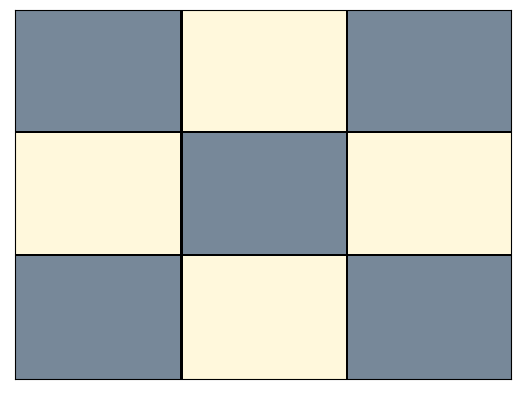

<class 'FileNotFoundError'>: [Errno 44] No such file or directory: './img/caballo.png'

In [36]:
I = {c.CenC.P([0,2]):True, c.CenC.P([1,2]):True, c.CenC.P([2,2]):True}
c.visualizar(I)

## Solución mediante SATtabla <a class="anchor" id="sat"></a>

([Volver al inicio](#inicio))

Ahora podemos ver el corazón de la solución a este y todos los demas problemas que desarrollemos: un SATsolver. Usaremos el SATtabla que implementamos anteriormente.

In [37]:
%%time
A = inorder_to_tree(Ytoria(c.reglas))
I = A.SATtabla()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 100 ms


Podemos decodificar el diccionario `I` obtenido para ver la solución:

In [38]:
if I != None:
    for k in I:
        print(c.CenC.escribir(k), I[k])
else:
    print('¡No hay solución!')

El caballo está en la casilla (0,0) False
El caballo está en la casilla (0,2) True
El caballo está en la casilla (1,2) True
El caballo está en la casilla (2,1) False
El caballo está en la casilla (2,2) True
El caballo está en la casilla (1,1) False
El caballo está en la casilla (2,0) False
El caballo está en la casilla (0,1) False
El caballo está en la casilla (1,0) False


O, mejor aún, podemos visualizar la solución:

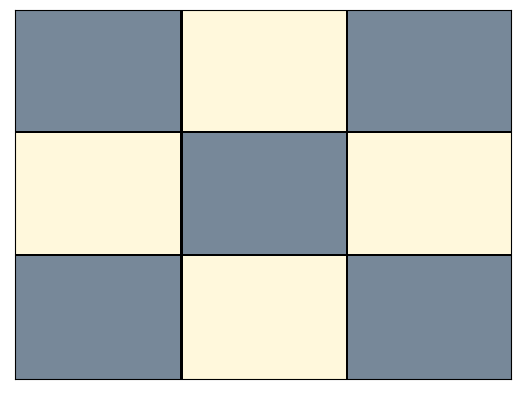

<class 'FileNotFoundError'>: [Errno 44] No such file or directory: './img/caballo.png'

In [39]:
if I != None:
    c.visualizar(I)
else:
    print('¡No hay solución!')

Vemos que la solución encontrada por SATtabla es muy rápida.

---

## Un problema más difícil <a class="anchor" id="prob2"></a>

([Volver al inicio](#inicio))

El propósito de esta sección es tratar de resolver un problema mediante el procedimiento que hemos descrito anteriormente. No obstante, el código presentará algunos problemas que tendremos que afrontar. Esto nos permitirá entrenarnos para afrontar las dificultades que se presentarán en la elaboración del proyecto.

Retomaremos aquí el problema con el que estudiamos la representación de situaciones. Buscamos llenar todas las casillas en una tabla 2x2 con un número de 0 a 3, sin repetir. Por ejemplo:

![ejemplo](img/tabla.png)

Tenemos tres restricciones que debemos implementar para resolver el problema:

1. Un número sólo está en una casilla.

$$\bigwedge_{x\in\{0,1\}}\bigwedge_{y\in\{0,1\}}\bigwedge_{n\in Numeros}\left(OenCasilla_{x,y,n}\to\neg\left(\bigvee_{(u,v)\neq (x,y)} OenCasilla_{u,v,n}\right)\right)$$

2. No hay más de un número en una casilla.

$$\bigwedge_{x\in\{0,1\}}\bigwedge_{y\in\{0,1\}}\bigwedge_{n\in Numeros}\left(OenCasilla_{x,y,n}\to\neg\left(\bigvee_{m\neq n} OenCasilla_{x,y,m}\right)\right)$$

3. Debe haber por lo menos un número en una casilla.

$$\bigwedge_{x\in\{0,1\}}\bigwedge_{y\in\{0,1\}}\left(\bigvee_{n\in Numeros}OenCasilla_{x,y,n}\right)$$


### Errores sintácticos

La implementación, con algunos errores, está en la librería `Problemas`.

In [40]:
from Problemas import Rejilla
from Logica import *

<class 'ModuleNotFoundError'>: No module named 'Problemas'

Instanciamos el objeto:

In [41]:
r = Rejilla(N=2, M=2)

Y ahora intentamos visualizar la regla 1:

In [42]:
print(r.reglas[0])
A = inorder_to_tree(r.reglas[0])
print(A.ver(r.NenC))

((((((((((((((((Ā>-((ĈOĄ)OČ)Y(Ĉ>-((ĀOĄ)OČ))Y(Ą>-((ĀOĈ)OČ))Y(Č>-((ĀOĈ)OĄ))Y(ā>-((ĉOą)Oč))Y(ĉ>-((āOą)Oč))Y(ą>-((āOĉ)Oč))Y(č>-((āOĉ)Oą))Y(Ă>-((ĊOĆ)OĎ))Y(Ċ>-((ĂOĆ)OĎ))Y(Ć>-((ĂOĊ)OĎ))Y(Ď>-((ĂOĊ)OĆ))Y(ă>-((ċOć)Oď))Y(ċ>-((ăOć)Oď))Y(ć>-((ăOċ)Oď))Y(ď>-((ăOċ)Oć))


<class 'AttributeError'>: 'NoneType' object has no attribute 'ver'

Este error aparece en la línea que usa el método `ver` de las fórmulas. No obstante, el método `ver` es correcto. Es decir, el problema no está aquí. Esto lo sabemos porque el error nos dice que un objeto de tipo `None` no tiene el atributo `ver`. Así pues, el error es que `A` es `None`. Corrámos solo la función `inorder_to_tree` para comprobarlo:

In [44]:
A = inorder_to_tree(r.reglas[0])
print(A)

None


Este error en `inorder_to_tree` surge porque la cadena no está bien escrita. Usualmente se debe a que hay un paréntesis faltante o mal puesto.

**Ejercicio 1:**

Revise el siguiénte código que genera la regla 1 y corrija el error. Observe que a la generación de fórmulas le hace falta incluir un paréntesis.

In [45]:
def regla1(self):
    casillas_num = [(n,x,y) for n in range(self.N*self.M) for x in range(self.N) for y in range(self.M)]
    lista = []
    for c in casillas_num:
        n,x,y = c
        otras_casillas = [(x1,y1) for x1 in range(self.N) for y1 in range(self.M) if (x1,y1) != (x,y)]
        lista_o = []
        for k in otras_casillas:
            lista_o.append(self.NenC.P([n,*k]))
        form = '(' + self.NenC.P([*c]) + '>-' + Otoria(lista_o) +')'
        lista.append(form)
    return Ytoria(lista)

setattr(Rejilla, "regla1", regla1)

A = inorder_to_tree(r.reglas[0])
print(A)

None


---

### Errores semánticos

Un tipo de error más complicado de ver es cuando la regla está correctamente escrita, pero no representa la restricción de manera correcta.

Por ejemplo, la regla 3 está escrita correctamente:

In [46]:
r = Rejilla(N=2)
A = inorder_to_tree(r.reglas[2])
print(A.ver(r.NenC))

((((((El número 0 está en la casilla (0,0) Y El número 1 está en la casilla (0,0)) Y El número 2 está en la casilla (0,0)) Y El número 3 está en la casilla (0,0)) Y (((El número 0 está en la casilla (0,1) Y El número 1 está en la casilla (0,1)) Y El número 2 está en la casilla (0,1)) Y El número 3 está en la casilla (0,1))) Y (((El número 0 está en la casilla (1,0) Y El número 1 está en la casilla (1,0)) Y El número 2 está en la casilla (1,0)) Y El número 3 está en la casilla (1,0))) Y (((El número 0 está en la casilla (1,1) Y El número 1 está en la casilla (1,1)) Y El número 2 está en la casilla (1,1)) Y El número 3 está en la casilla (1,1)))


No obstante, ella no cumple el papel que debe cumplir. Esto se puede detectar al tratar de resolver el problema con esta regla y obtener resultados indeseados.

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 205 ms


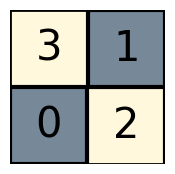

In [64]:
%%time
r = Rejilla(N=2)
A = inorder_to_tree(Ytoria(r.reglas))
I = A.SATtabla()
if I != None:
    r.visualizar(I)
else:
    print('¡No hay solución!')

Si corremos la regla 3 solamente, obtenemos lo siguiente:

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 62 ms


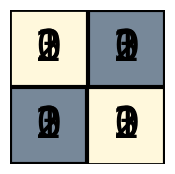

In [65]:
%%time
r = Rejilla(N=2)
A = inorder_to_tree(r.reglas[2])
I = A.SATtabla()
if I != None:
    r.visualizar(I)
else:
    print('¡No hay solución!')

**Ejercicio 2:**

Corrija la regla 3 para que represente la restricción de manera apropiada.

In [66]:
def regla3(self):
    casillas = [(x,y) for x in range(self.N) for y in range(self.M)]
    lista = []
    for c in casillas:
        lista_o = []
        for n in range(self.N*self.M):
            lista_o.append(self.NenC.P([n,*c]))
        lista.append(Otoria(lista_o))
    return Otoria(lista)

setattr(Rejilla, "regla3", regla3)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 198 ms


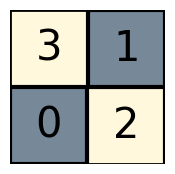

In [67]:
%%time
r = Rejilla(N=2)
A = inorder_to_tree(Ytoria(r.reglas))
I = A.SATtabla()
if I != None:
    r.visualizar(I)
else:
    print('¡No hay solución!')

---

# Situaciones más complejas y comparación de tiempos <a class="anchor" id="comp"></a>

([Volver al inicio](#inicio))

Observe que podemos cambiar los parámetros `N` y `M` para cambiar el tamaño de la rejilla:

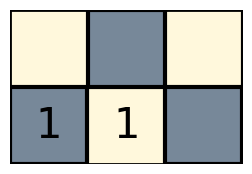

In [68]:
r = Rejilla(N=3, M=2)
I = {r.NenC.P([1,0,0]):True, r.NenC.P([1,1,0]):True}
r.visualizar(I)

Tal vez queramos aplicar el mismo algoritmo de solución a este problema más grande. No obstante, el tiempo de ejecución es prohibitivo:

In [69]:
%%time
r = Rejilla(N=3, M=2)
A = inorder_to_tree(Ytoria(r.reglas))
I = A.SATtabla()
r.visualizar(I)

<class 'MemoryError'>: 

Este es un problema muy serio. Ni siquiera el algoritmo de los tableros semánticos puede venir a rescatarnos (observe que el objeto `Formula` ya trae implementado el `SATtableaux`):

In [ ]:
%%time
r = Rejilla(N=3, M=2)
A = inorder_to_tree(Ytoria(r.reglas))
I = A.SATtableaux()
r.visualizar(I)

---

## En este notebook usted aprendió

1. El esquema de solución de problemas mediante lógica proposicional.
2. Cada problema requiere una definición particular de sus restricciones y su implementación en lógica proposicional.
3. Cualquiera de estos problemas se resuelve (por lo menos de manera teórica) mediante el mismo algoritmo: un SATsolver.
4. Los SATsolvers que tenemos hasta este momento no son para nada eficientes, así que necesitamos algoritmos más poderosos.